## Machine Learning Project

### Intro

This report will analyze subscription data from mobile carrier Megaline's subscribers.  Megaline would like to suggest a new plan and depending on their usage, it would reccommend the Smart or Ultra plan.

For this task we will build several machine learning models using python, and find the more accurate performing one to make predictions about their users who have not yet upgraded to one of the newer plans.  In this test the accuracy threshold is 0.75 (75% accurate).

### Importing the data

The data that we are using is precleaned from a previous project but we will import the data and check that everything looks normal.  Each row in our dataframe represents one user's monthly behavior.  Additionally we import several libraries that will help build our models.

In [1]:
#import libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree

In [2]:
#import data
df= pd.read_csv('/datasets/users_behavior.csv')
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
pd.isna(df).sum()

calls       0
minutes     0
messages    0
mb_used     0
is_ultra    0
dtype: int64

In [5]:
df.duplicated().sum()

0

Data still looks good.  All 3214 have values for every column and there are no missing values or duplicated rows.  On to model building.

## Building Models

We will test out three different models for this test:  decision trees, random forests and linear regression.


Before we start building models we will specify which column is the column that we are trying to predict (the target) and which columns contain the information that determines the target (the features).

In this case the we are trying to figure out which plan to recommend and that information is in the 'is_ultra' column.  A 0 in that column corresponds to the Smart plan and a 1 corresponds to the Ultra plan.  The respective user behavior for the plan is alluded to in that same row.

### Splitting the data
The data also needs to be split into three groups.  Training data to train the model, validation data to fine tune the model, and testing data to test the model's accuracy.

In [6]:
#define features and target
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

In [7]:
#split the data using train_test_split
#split data into training (60%) and validation (40%) data
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size = 0.4, random_state=26)

In [8]:
#split the validation data into validation and test sets
features_valid, features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5, random_state=26)

In [9]:
df.shape

(3214, 5)

In [10]:
display(features.shape)
display(target.shape)

(3214, 4)

(3214,)

In [11]:
display(features_train.shape)
display(target_train.shape)

(1928, 4)

(1928,)

In [12]:
display(features_valid.shape)
display(target_valid.shape)

(643, 4)

(643,)

In [13]:
display(features_test.shape)
display(target_test.shape)

(643, 4)

(643,)

In [14]:
#check that it was split correctly into 60/20/20
#training data should be 60% of whole dataset
print(len(features_train)/len(features))

0.5998755444928439


In [15]:
#valid and test (each 643) should be 20% of whole data
print(len(features_valid)/len(features))

0.2000622277535781


Everything checks out we are good to go.

### Decision Trees

Our first model will be a decision tree. The model will find the depth with the highest accuracy.

In [16]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
for depth in range (1,6):
    model = DecisionTreeClassifier(max_depth=depth, random_state=26)
    #train tree
    model.fit(features_train, target_train)
    #make predictions on validation
    predictions_valid = model.predict(features_valid)
    #predictions score
    valid_result = accuracy_score(target_valid, predictions_valid)
    print(depth, valid_result)
    if valid_result > best_result_tree:
        best_model_tree = model
        best_result_tree = valid_result
        best_depth_tree = depth

print(f'Best decision tree model on validation set has max_depth = {best_depth_tree} with accuracy score of: {best_result_tree}')

1 0.744945567651633
2 0.7558320373250389
3 0.7667185069984448
4 0.7776049766718507
5 0.7651632970451011
Best decision tree model on validation set has max_depth = 4 with accuracy score of: 0.7776049766718507


max_depth = 4 wins with 77.7% accuracy in the validation set.

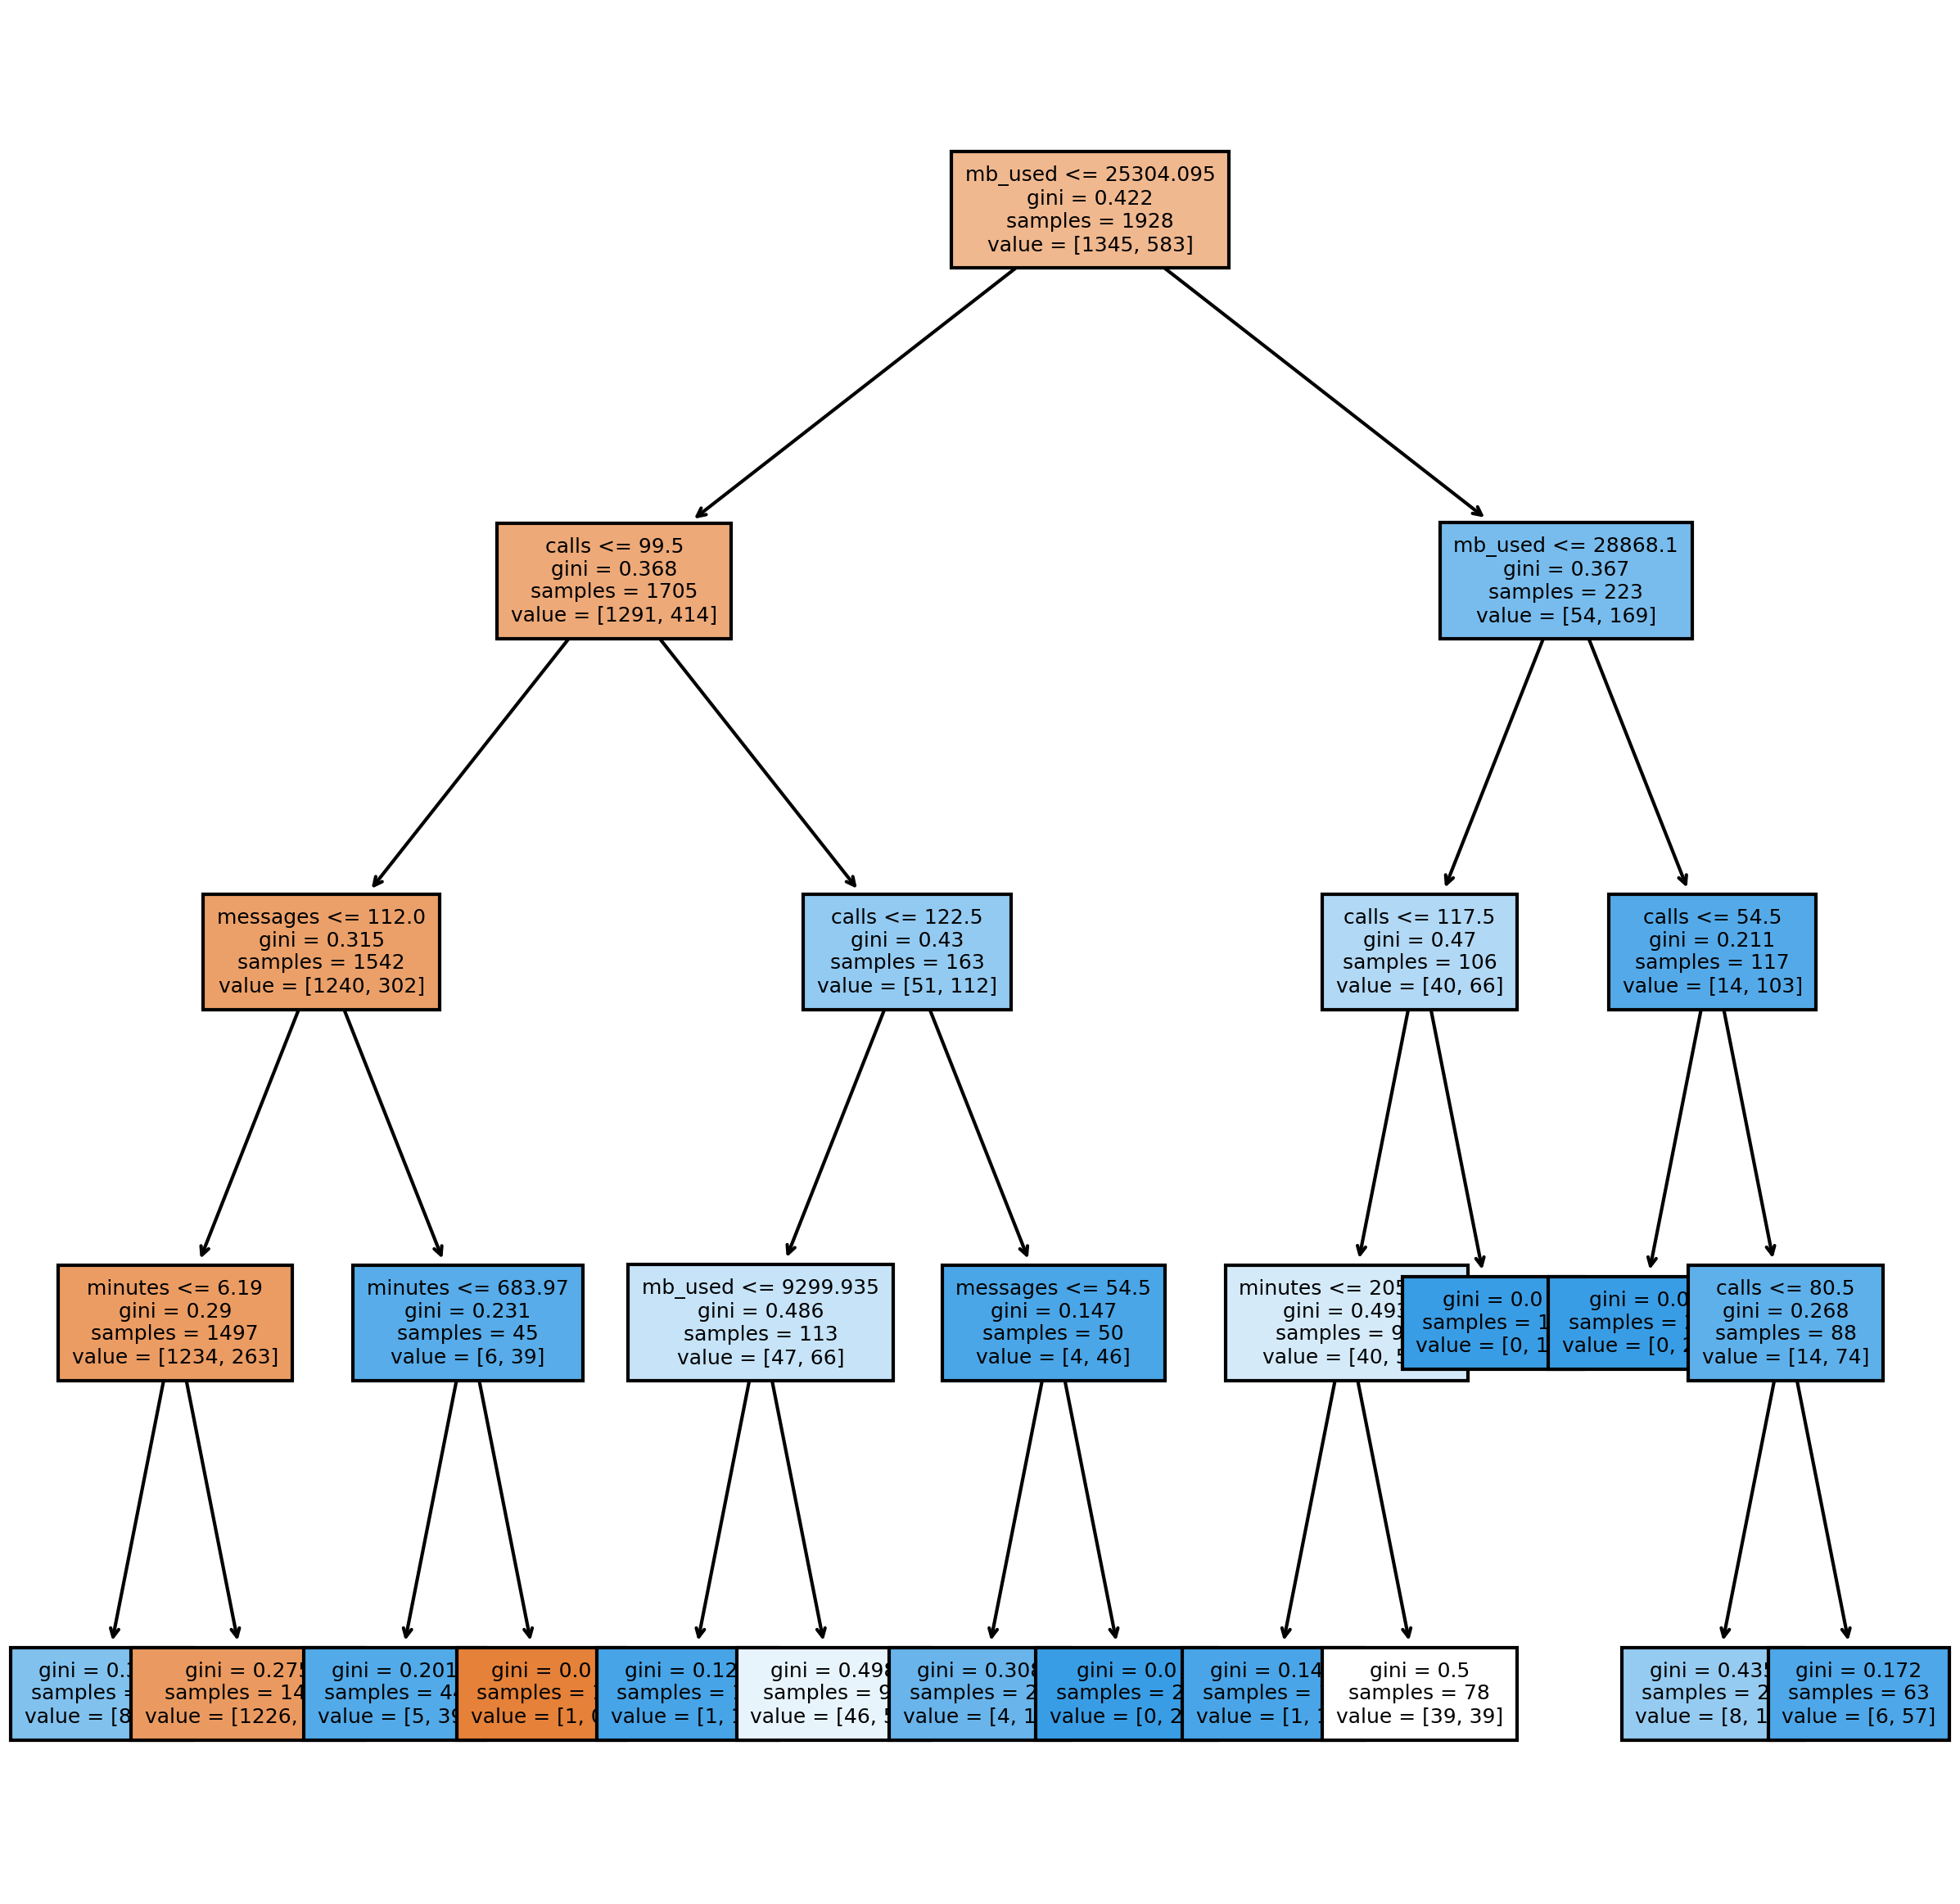

In [17]:
#figure for the decision tree
import matplotlib.pyplot as plt
dtc_model = DecisionTreeClassifier(random_state=26, max_depth=4)
dtc_model.fit(features_train,target_train)
predictions_valid = dtc_model.predict(features_valid)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10,10), dpi = 300)
tree.plot_tree(dtc_model,feature_names=features_train.columns,filled=True, fontsize=6);

The decision tree tested out models with max_depth of 1-5 and got an accuracy scores between 0.74 and 0.77.  
The best depth was max_depth=4 with an accuracy of 0.77.  Above is a graphical representation of that model.

We will test this model later with the test data.

### Random Forest Classifier

Random Forest is more accurate than decision trees because it forms a number of trees and then finds the best model within them. However, because it does a lot of work, the code takes longer to execute. Additionally, there is the danger of overfitting.


In [18]:
best_model_forest = None
best_result_forest = 0
best_depth_forest = 0
best_est = 0
for est in range (10,51,1):
    for depth in range (1,11):
        model = RandomForestClassifier(n_estimators = est, max_depth=depth, random_state=26)
        #train model
        model.fit(features_train, target_train)
        #make predictions on validation
        predictions_valid = model.predict(features_valid)
        #predictions score
        valid_result = accuracy_score(target_valid, predictions_valid)
        if valid_result > best_result_forest:
            best_model_forest = model
            best_result_forest = valid_result
            best_depth_forest = depth
            best_est = est

print(f'Best random forest model on validation set has n_estimators = {best_est}, max_depth = {best_depth_forest} with accuracy score of: {best_result_forest}')


Best random forest model on validation set has n_estimators = 41, max_depth = 9 with accuracy score of: 0.8102643856920684


Often a model with lower depth is desirable.  Let's see if we can get as good an accuracy with less depth.

In [ ]:
#testing the forest with less depth
best_model_forest_x = None
best_result_forest_x = 0
best_depth_forest_x = 0
best_est_x = 0
for est in range (10,51,1):
    for depth in range (1,7):
        model_x = RandomForestClassifier(n_estimators = est, max_depth=depth, random_state=26)
        #train model
        model_x.fit(features_train, target_train)
        #make predictions on validation
        predictions_valid_x = model_x.predict(features_valid)
        #predictions score
        valid_result_x = accuracy_score(target_valid, predictions_valid_x)
        if valid_result_x > best_result_forest_x:
            best_model_forest_x = model_x
            best_result_forest_x = valid_result_x
            best_depth_forest_x = depth
            best_est_x = est

print(f'Best random forest model on validation set has n_estimators = {best_est_x}, max_depth = {best_depth_forest_x} with accuracy score of: {best_result_forest_x}')


Running the random forest with less depth yielded a lower accuracy score with the validation data (80.4% vs 81.03%)

In [ ]:
#Running this Random Forest with the depth of 5
model_forest_5 = RandomForestClassifier(n_estimators = 21, max_depth=5, random_state=26)
#train model
model_forest_5.fit(features_train, target_train)
#make predictions on validation
predictions_valid_forest_5 = model_forest_5.predict(features_valid)
#predictions score
valid_result_forest_5 = accuracy_score(target_valid, predictions_valid_forest_5)
print('Accuracy for random forest model (n_estimators = 21 and max_depth = 5) on validation data: ', valid_result_forest_5.round(4))

Choosing between a range of 10-50 trees and varying depths from 1-10, the random forest model chose the best fit of n_estimators = 41 and a max depth of 9.  This gave an 81.0% accuracy with the validation data.

The random forest was ran again with a lower depth range (1-6) as a test.  In that case, the best model had a depth of 5.  When this model was ran, the accuracy score went down compared to the model with depth of 9.  Let's stick with the first model.

### Logistic Regression

Logistic regression is also a classification algorithm that in this case will predict the probability of the event going to one plan or the other.  It is faster than the random forest and will not cause overfitting but is usually less accurate.

In [19]:
LR_model = LogisticRegression(random_state=26, solver='liblinear')
#training the model
LR_model.fit(features, target)
score_train_LR= LR_model.score(features, target)
print('Logistic Regression Training Score: ', score_train_LR)
score_valid_LR = LR_model.score(features_valid, target_valid)
print('Logistic Regression Validation Score: ', score_valid_LR)

Logistic Regression Training Score:  0.7426882389545737
Logistic Regression Validation Score:  0.7418351477449455


The logistic regression model performed well in the training and performed slightly worse with the validation data (74.26% vs 74.18%).  The accuracy of 74.18% points to a good guessing probability of this test but is unfortunately lower than our 75% threshold.

## Testing the models with the test data

The models did well in the training and validation sections.  
Let's review which model did the best.

In [20]:
print('Accuracy Scores for Validation of each Model:')
print(f'Decision Tree: max_depth = {best_depth_tree} with accuracy score of: {best_result_tree.round(4)}')
print(f'Random Forest: n_estimators = {best_est}, max_depth = {best_depth_forest} with accuracy score of: {best_result_forest.round(4)}')

print('Logistic Regression Validation Score: ', score_valid_LR.round(4))

Accuracy Scores for Validation of each Model:
Decision Tree: max_depth = 4 with accuracy score of: 0.7776
Random Forest: n_estimators = 41, max_depth = 9 with accuracy score of: 0.8103
Logistic Regression Validation Score:  0.7418


Out of the three tests, the random forest did best with an accuracy score of 81.03% using n_estimators = 41 and max_depth = 9.
Next is the decision tree with a score of 77.76% and max_depth = 4.
In last place and below our threshold is the logistic regression with a score of 74.18%

Now it's time to test the models with the best hyperparameters with the test data.


In [21]:
#testing for Decision Tree
model_tree = DecisionTreeClassifier(max_depth=4, random_state=26)
#train tree
model_tree.fit(features_train, target_train)
#make predictions on validation
predictions_valid_tree = model_tree.predict(features_valid)
#predictions score
valid_result_tree = accuracy_score(target_valid, predictions_valid_tree)
test_predictions_tree = model_tree.predict(features_test)
test_score_tree = accuracy_score(target_test, test_predictions_tree)
print('Decision Tree Test Accuracy Score: ', test_score_tree)

Decision Tree Test Accuracy Score:  0.7744945567651633


In [22]:
#testing for Random Forest
model_forest = RandomForestClassifier(n_estimators = 41, max_depth=9, random_state=26)
#train model
model_forest.fit(features_train, target_train)
#make predictions on validation
predictions_valid_forest = model_forest.predict(features_valid)
#predictions score
valid_result_forest = accuracy_score(target_valid, predictions_valid_forest)
test_predictions_forest = model_forest.predict(features_test)
test_score_forest = accuracy_score(target_test, test_predictions_forest)
print('Random Forest Test Accuracy Score: ', test_score_forest)

Random Forest Test Accuracy Score:  0.8009331259720062


In [23]:
test_predictions_LR = LR_model.predict(features_test)                 
test_score_LR = accuracy_score(target_test, test_predictions_LR)
print('Logistic Regression Test Accuracy Score: ', test_score_LR)

Logistic Regression Test Accuracy Score:  0.7262830482115086


In [24]:
#display all validation and test accuracy scores
print('Accuracy Scores for Validation of each Model:')
print()
print(f'Random Forest: n_estimators = {best_est}, max_depth = {best_depth_forest} with accuracy score of: {best_result_forest.round(4)}')
print(f'Decision Tree: max_depth = {best_depth_tree} with accuracy score of: {best_result_tree.round(4)}')
print('Logistic Regression Validation Score: ', score_valid_LR.round(4))
print()
print('Accuracy Scores for Test of each Model:')
print()
print('Random Forest Test Accuracy Score: ', test_score_forest.round(4))
print('Decision Tree Test Accuracy Score: ', test_score_tree.round(4))
print('Logistic Regression Test Accuracy Score: ', test_score_LR.round(4))

Accuracy Scores for Validation of each Model:

Random Forest: n_estimators = 41, max_depth = 9 with accuracy score of: 0.8103
Decision Tree: max_depth = 4 with accuracy score of: 0.7776
Logistic Regression Validation Score:  0.7418

Accuracy Scores for Test of each Model:

Random Forest Test Accuracy Score:  0.8009
Decision Tree Test Accuracy Score:  0.7745
Logistic Regression Test Accuracy Score:  0.7263


In [25]:
#display everything in a table:
# Data
data = {
    'Model': ['Decision Tree', 'Random Forest', 'Logistic Regression'],
    'Hyperparameters': [f'max_depth = {best_depth_tree}', 
                   f'n_estimators = {best_est}, max_depth = {best_depth_forest}', 
                   'Default'],
    'Validation Accuracy': [best_result_tree.round(4), 
                            best_result_forest.round(4), 
                            score_valid_LR.round(4)],
    'Test Accuracy': [test_score_tree.round(4), test_score_forest.round(4), test_score_LR.round(4)]
}

# Creating DataFrame
sum = pd.DataFrame(data)
sum_sorted = sum.sort_values(by=['Test Accuracy'], ascending=False, ignore_index=True)
sum_sorted

,Model,Hyperparameters,Validation Accuracy,Test Accuracy
0,Random Forest,"n_estimators = 41, max_depth = 9",0.8103,0.8009
1,Decision Tree,max_depth = 4,0.7776,0.7745
2,Logistic Regression,Default,0.7418,0.7263


 The Random Forest model performed best with a validation accuracy of 81.03% and a test accuracy of 80.09% in the case with n_estimators = 41 and max_depth = 9.  The lower test accuracy score points to some overfitting but not much.
 
The small Decision Tree also did well with a test accuracy score of 77.45%

Logistic Regression came in last place with 72.63% and failed to pass our threshold of 75%.  Furthermore, the lower test score for logistic regression (72.62% vs 74.18%) means that the model experienced overfitting when training with the data.

In [26]:
#Look at precision and recall with a confusion matrix for the random forest
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(target_test, test_predictions_forest)

In [27]:
cm

array([[407,  27],
       [101, 108]])

In [28]:
TP = cm[1, 1]
FP = cm[0, 1]
FN= cm[1, 0]
TN=cm[0,0]

In [29]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
print("precision:",precision)
print("recall:",recall)

precision: 0.8
recall: 0.5167464114832536


Further ways of measuring the random forest model's performance is with a confusion matrix, recall and precision.

The meaning of the confusion matrix array is as follows:
Of the test data, the model picked correctly 407 customers that chose the 'Smart' plan.  It also incorrectly predicted another 101 customers for the 'Smart' plan that infact chose 'Ultra' (the 80.09% accuracy).  

It correctly chose 108 customers that went for 'Ultra' but also chose 27 customers that infact chose 'Smart' (80% precision).  This is a low error.
Of the total 108 customers it predicted for 'Ultra', it mistook 101 customers that also chose 'Ultra' for 'Smart' customers (the low 51% precision)

The 80% precision is good because it caught a lot of customers that actually went for the ultra plan but miscatorizing 'Ultra' customers as 'Smart' could lead to loss income from the more expensive 'Ultra' plan.  The low recall is alarming but not extremely troubling if the customers upgrade in the end.


## Conclusion

The most accurate machine learning model was the random forest: 80.09% accuracy with the test data (n_estimators = 41 and max_depth = 9).  However, this model was made with a large depth and has the possiblility of slight overfitting especially since the test accuracy is slightly less than the validation accuracy.  